In [1]:

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# open csv

In [2]:
# open preprocessed data
df = pd.read_csv('../data/processed_reviews.csv')
without_dupe = df.drop_duplicates(subset=['review_text'], inplace=False)
# select subcategory to analyze
# subcategory = 'BODY CARE BODY LOTION'
subcategory = 'SPRAY CLEANERS BLEACH CLEANERS'
label = "spray"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(4731, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
11,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,it do the work that be enough for me,5.0,Finding the Perfect Product,Clorox
12,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i use it in the restroom and in the kitchen fo...,5.0,Disinfectant spray recommendations and reviews...,Clorox
16,CVS Total Home,"Total Home Cleaner With Bleach, 32 OZ",2024-07-01,CVS,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i use this in my shower that have pink mold an...,5.0,Effective products for mold and mildew removal...,Competitor
69,Clorox,Clorox® Clean-Up® Cleaner + Bleach1 Value Pack...,2024-07-01,Amazon,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i appreciate the value you get with this 3pack...,5.0,Disinfectant spray recommendations and reviews...,Clorox
116,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Target,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,stay at a beach condo for several month last y...,5.0,Bathroom cleaning solutions,Clorox


In [3]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_90438/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


In [4]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1
total_topics = get_number_topics(df.shape[0])
total_topics

6

In [5]:
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarithmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)


    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight


    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))


    return num_topics

total = df.shape[0]
print("number of reviews", total)
# cur_num_topics = 0
# for i in range(1, 6):
#     print(f'num topics for rating {i} with {len(grouped[i])} reviews:')
#     print(calculate_num_topics(len(grouped[i]), total, total_topics, i))
#     cur_num_topics += calculate_num_topics(len(grouped[i]), total, total_topics, i)
# print(cur_num_topics)


number of reviews 4731


## calculated number of topics per rating

In [6]:
num_topics_per_rating = {}
for i in range(1, 6):
    num_topics_per_rating[i] = calculate_num_topics_star_rating(total_topics, i)
    print(f'Rating {i} with {len(grouped[i])} reviews: {num_topics_per_rating[i]} topics')

Rating 1 with 272 reviews: 2 topics
Rating 2 with 97 reviews: 2 topics
Rating 3 with 165 reviews: 2 topics
Rating 4 with 420 reviews: 2 topics
Rating 5 with 3777 reviews: 1 topics


# BERTopic models

In [7]:
def create_topic_model(text, num_topics):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    pca_model = PCA(n_components=10)

    # Step 3 - Cluster reduced embeddings
    cluster_model = KMeans(n_clusters=num_topics)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired()

    topic_model = BERTopic(
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=pca_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model                # Step 5 - Extract topic words
       # representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
    )

    # Fit BERTopic model
    topic_model.fit_transform(text)
    return topic_model

In [8]:
import time
models = {}
total_time = 0
for rating, reviews in grouped.items():
    print(f'Rating {rating} with {len(reviews)} reviews')
    num_topics = num_topics_per_rating[rating]
    start = time.time()
    models[rating] = create_topic_model(reviews, num_topics)
    time_taken = time.time() - start
    print(f'Time taken: {time_taken} seconds')
    total_time += time_taken
    print('\n')

Rating 1.0 with 272 reviews


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time taken: 24.388078927993774 seconds


Rating 2.0 with 97 reviews
Time taken: 11.285379886627197 seconds


Rating 3.0 with 165 reviews
Time taken: 12.436420202255249 seconds


Rating 4.0 with 420 reviews
Time taken: 23.722146034240723 seconds


Rating 5.0 with 3777 reviews
Time taken: 48.93438100814819 seconds




took 25.7 s to create models with pca components = 5

## number of topics generated per rating

In [9]:
for rating, model in models.items():
    print(f'Rating {rating} with {len(model.get_topic_freq())} topics')
    print(model.get_topic_freq())
    print('\n')

Rating 1.0 with 2 topics
   Topic  Count
1      0    189
0      1     83


Rating 2.0 with 2 topics
   Topic  Count
0      0     52
1      1     45


Rating 3.0 with 2 topics
   Topic  Count
0      0    101
1      1     64


Rating 4.0 with 2 topics
   Topic  Count
0      0    287
1      1    133


Rating 5.0 with 1 topics
   Topic  Count
0      0   3777




## create dataframe of topics

In [10]:
df_topics = pd.DataFrame(columns=['star_rating', 'topic_number', 'count', 'topic_words'])
for rating, model in models.items():
    res = model.get_topic_info()
    for index, row in res.iterrows():
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'topic_number': [row['Topic']],
            'count': [row['Count']],
            'topic_words': [row['Representation']]
        })
        df_topics = pd.concat([df_topics, new_row], ignore_index=True)

df_topics

,star_rating,topic_number,count,topic_words
0,1.0,0,189,"[bottle, product, bleach, leak, spray, box, cl..."
1,1.0,1,83,"[order, item, receive, charge, ship, return, p..."
2,2.0,0,52,"[spray, bottle, clean, use, smell, work, produ..."
3,2.0,1,45,"[leak, box, product, bottle, like, bleach, ord..."
4,3.0,0,101,"[clean, product, spray, use, smell, bleach, li..."
5,3.0,1,64,"[bottle, leak, order, box, product, item, pack..."
6,4.0,0,287,"[clean, use, bleach, smell, bathroom, product,..."
7,4.0,1,133,"[bottle, leak, product, spray, good, work, ref..."
8,5.0,0,3777,"[clean, use, product, great, smell, love, bath..."


## label reviews with topic

In [11]:
# label reviews in df with topics
labeled_reviews = pd.DataFrame()
for rating, model in models.items():
    labeled_reviews = pd.concat([labeled_reviews, model.get_document_info(grouped[rating])], ignore_index=True)
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,my first time attempt to order this buster all...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False
1,one bottle leak out into the box toss the enti...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False
2,usually i like these product but the item spil...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False
3,receive spilling in my bag,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False
4,package be receive in a home depot box with ob...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False
...,...,...,...,...,...,...,...
4726,i be introduce to fantastik by my mother many ...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False
4727,this one be best one to clean dirty in your ho...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False
4728,work great for stubborn stain have a strong sc...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False
4729,i usually try to stay away from chemical howev...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False


## distribution of topics for each rating

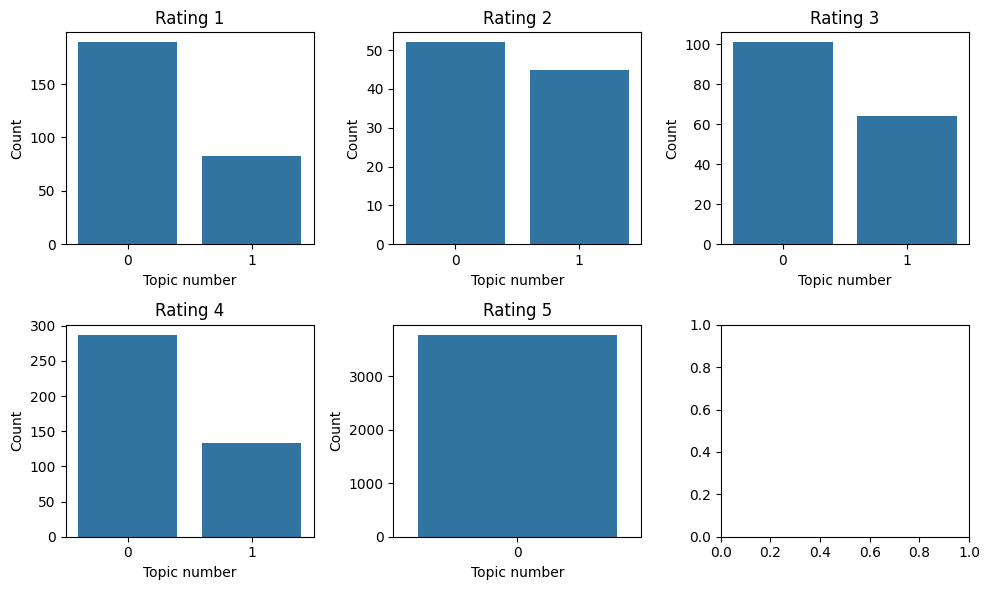

In [12]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# iterate over ratings and plot distribution of topics using count column
for i, rating in enumerate(range(1, 6)):
    ax = axs[i // 3, i % 3]
    sns.barplot(x='topic_number', y='count', data=df_topics[df_topics['star_rating'] == rating], ax=ax)
    ax.set_title(f'Rating {rating}')
    ax.set_xlabel('Topic number')
    ax.set_ylabel('Count')

# Display all subplots together
plt.tight_layout()
plt.show()

# generate phrases for topics

In [13]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

# generate phrases for each topic in df_topics and add generated phrase to new column 'phrase'
df_topics['phrase'] = df_topics.apply(lambda x: process_input(x['topic_words'], x['star_rating']), axis=1)
df_topics

,star_rating,topic_number,count,topic_words,phrase
0,1.0,0,189,"[bottle, product, bleach, leak, spray, box, cl...",Bleach leaks or defective packaging
1,1.0,1,83,"[order, item, receive, charge, ship, return, p...","""Walmart order failed to ship or deliver"""
2,2.0,0,52,"[spray, bottle, clean, use, smell, work, produ...","""Spray bottle cleaning product with okay scent..."
3,2.0,1,45,"[leak, box, product, bottle, like, bleach, ord...","""Defective or damaged product upon arrival"""
4,3.0,0,101,"[clean, product, spray, use, smell, bleach, li...",Effective cleaning spray with pleasant smell
5,3.0,1,64,"[bottle, leak, order, box, product, item, pack...","""Bottle leak issues in package arrive"""
6,4.0,0,287,"[clean, use, bleach, smell, bathroom, product,...",Bleach product smells great after use in bathr...
7,4.0,1,133,"[bottle, leak, product, spray, good, work, ref...","""Bottle and spray product works well, good pri..."
8,5.0,0,3777,"[clean, use, product, great, smell, love, bath...","""Effective cleaning product with pleasant smell"""


In [14]:
# merge star_rating from df with labeled_reviews, drop review_text column
labeled_reviews = labeled_reviews.merge(df[['review_text', 'star_rating']], left_on='Document', right_on='review_text', how='left').drop(columns=['review_text'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating
0,my first time attempt to order this buster all...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0
1,one bottle leak out into the box toss the enti...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False,1.0
2,usually i like these product but the item spil...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False,1.0
3,receive spilling in my bag,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0
4,package be receive in a home depot box with ob...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0
...,...,...,...,...,...,...,...,...
4726,i be introduce to fantastik by my mother many ...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0
4727,this one be best one to clean dirty in your ho...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0
4728,work great for stubborn stain have a strong sc...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0
4729,i usually try to stay away from chemical howev...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0


In [15]:
# merge phrases with labeled_reviews
labeled_reviews = labeled_reviews.merge(df_topics[['star_rating', 'topic_number', 'phrase']], left_on=['Topic', 'star_rating'], right_on=['topic_number', 'star_rating'], how='left').drop(columns=['topic_number'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating,phrase
0,my first time attempt to order this buster all...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0,"""Walmart order failed to ship or deliver"""
1,one bottle leak out into the box toss the enti...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False,1.0,Bleach leaks or defective packaging
2,usually i like these product but the item spil...,0,0_bottle_product_bleach_leak,"[bottle, product, bleach, leak, spray, box, cl...",[this cleaner be great i love to use it in my ...,bottle - product - bleach - leak - spray - box...,False,1.0,Bleach leaks or defective packaging
3,receive spilling in my bag,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0,"""Walmart order failed to ship or deliver"""
4,package be receive in a home depot box with ob...,1,1_order_item_receive_charge,"[order, item, receive, charge, ship, return, p...","[this not what i order, i never receive the or...",order - item - receive - charge - ship - retur...,False,1.0,"""Walmart order failed to ship or deliver"""
...,...,...,...,...,...,...,...,...,...
4726,i be introduce to fantastik by my mother many ...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0,"""Effective cleaning product with pleasant smell"""
4727,this one be best one to clean dirty in your ho...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0,"""Effective cleaning product with pleasant smell"""
4728,work great for stubborn stain have a strong sc...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0,"""Effective cleaning product with pleasant smell"""
4729,i usually try to stay away from chemical howev...,0,0_clean_use_product_great,"[clean, use, product, great, smell, love, bath...",[clorox clean up cleaner with bleach be wonder...,clean - use - product - great - smell - love -...,False,5.0,"""Effective cleaning product with pleasant smell"""


# evaluate quality of generated phrases

In [16]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, df):
    model = SentenceTransformer(model_name)
    reviews = df['Document'].tolist()
    phrases = df['phrase'].tolist()
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores


In [17]:
import time

model = 'all-MiniLM-L6-v2'

start = time.time()
scores = similarity_scores(model, labeled_reviews)
end = time.time()
labeled_reviews['similarity_score'] = scores
print(f"Time taken for {model}: {end - start}")

Time taken for all-MiniLM-L6-v2: 47.19843101501465


In [18]:
# print average similarity score for each rating/topic
avg_scores = labeled_reviews.groupby(['star_rating', 'Topic'])['similarity_score'].mean().reset_index()
avg_scores

,star_rating,Topic,similarity_score
0,1.0,0,0.369294
1,1.0,1,0.228430
2,2.0,0,0.440742
3,2.0,1,0.261991
4,3.0,0,0.450640
5,3.0,1,0.402691
6,4.0,0,0.502889
7,4.0,1,0.331194
8,5.0,0,0.453949


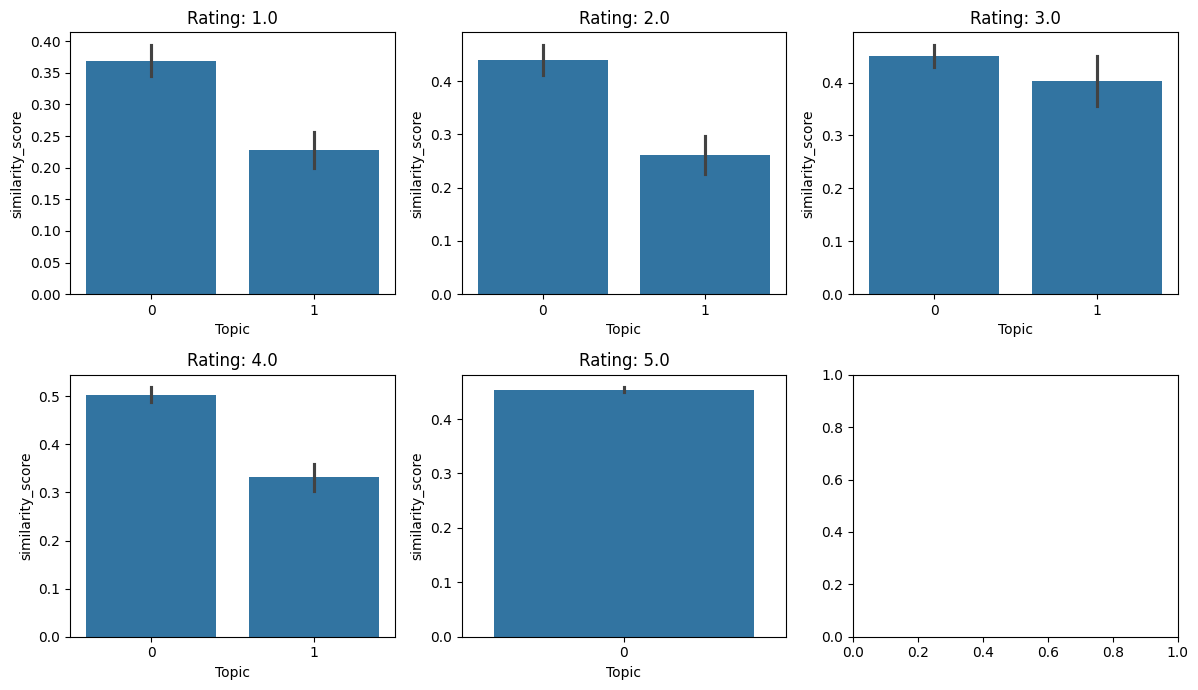

In [19]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in labeled_reviews['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=labeled_reviews[labeled_reviews['star_rating'] == rating], x='Topic', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [20]:
# print all topic phrases
for i, row in df_topics.iterrows():
    print(f"{"-" * 100}\nRating: {row['star_rating']} Topic: {row['topic_number']} Phrase: {row['phrase']}\n")
    # print words for the topic
    print(row['topic_words'])

----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 0 Phrase: Bleach leaks or defective packaging

['bottle', 'product', 'bleach', 'leak', 'spray', 'box', 'clorox', 'work', 'use', 'buy']
----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 1 Phrase: "Walmart order failed to ship or deliver"

['order', 'item', 'receive', 'charge', 'ship', 'return', 'product', 'deliver', 'walmart', 'didnt']
----------------------------------------------------------------------------------------------------
Rating: 2.0 Topic: 0 Phrase: "Spray bottle cleaning product with okay scent and work"

(waiting for further confirmation that this meets your requirements)

['spray', 'bottle', 'clean', 'use', 'smell', 'work', 'product', 'bleach', 'good', 'time']
----------------------------------------------------------------------------------------------------
Rating: 2.0 Topic: 1 Phr

In [21]:
# keep Document, phrase, Topic, star_rating, Top_n_words, similarity_score, and standardize column names
to_save = labeled_reviews[['Document', 'phrase', 'Topic', 'star_rating', 'Top_n_words', 'similarity_score']]
to_save.columns = ['review_text', 'topic', 'topic_number', 'star_rating', 'topic_words', 'similarity_score']
to_save.to_csv(f'../outputs/bertopic_{label}_kmeans.csv', index=False)

In [22]:
# average similarity scores for each rating
avg_scores_per_rating = avg_scores.groupby('star_rating')['similarity_score'].mean().reset_index()
avg_scores_per_rating

,star_rating,similarity_score
0,1.0,0.298862
1,2.0,0.351366
2,3.0,0.426666
3,4.0,0.417041
4,5.0,0.453949


In [23]:
overall_avg_score = avg_scores['similarity_score'].mean()
overall_avg_score

np.float32(0.38242438)